In [1]:
#!pip install imswitchclient # install the imswitchclient package
import imswitchclient.ImSwitchClient as imc 
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
from skimage.registration import phase_cross_correlation

Laser Name:  LED


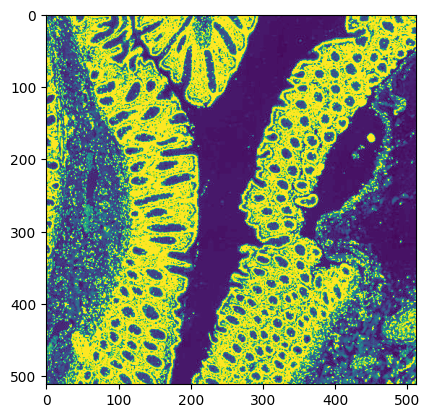

0.7056939601898193


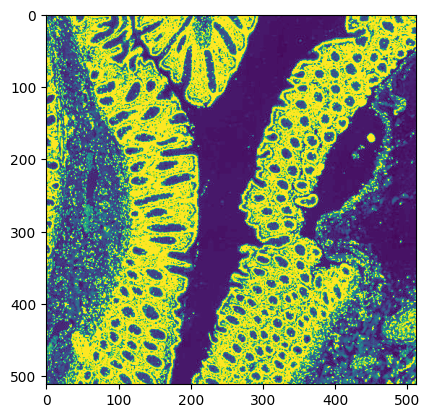

0.612095832824707


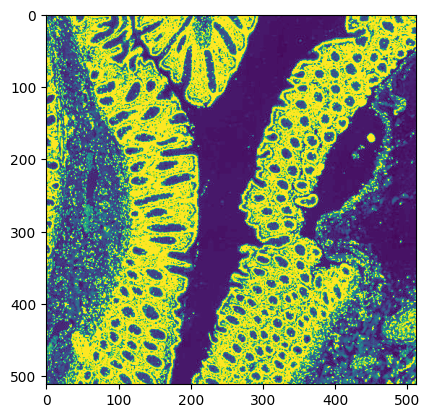

0.5551726818084717


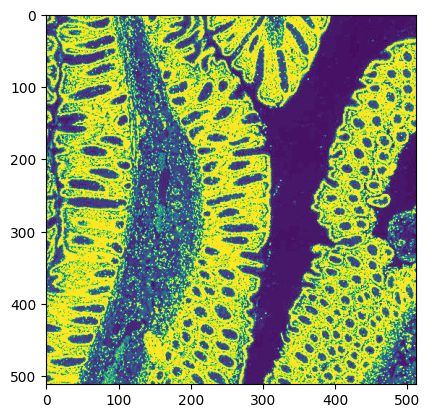

0.504180908203125


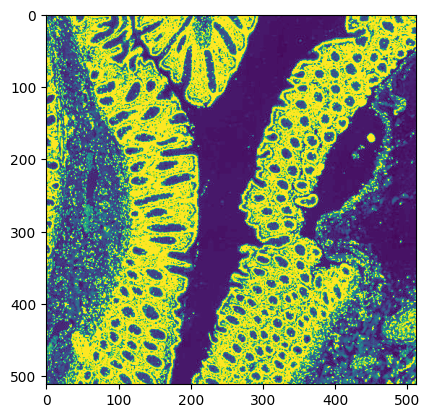

0.7863569259643555


In [3]:

# Initialize the client
client = imc.ImSwitchClient(host="0.0.0.0", isHttps=False, port=8001)

# Retrieve the first positioner's name and current position
positioner_names = client.positionersManager.getAllDeviceNames()
positioner_name = positioner_names[0]
currentPositions = client.positionersManager.getPositionerPositions()[positioner_name]
initialPosition = (currentPositions["X"], currentPositions["Y"])

# turn on illumination
mLaserName = client.lasersManager.getLaserNames()[0]
client.lasersManager.setLaserActive(mLaserName, True)
client.lasersManager.setLaserValue(mLaserName, 1023)

print("Laser Name: ", mLaserName)

positionList = [(0,0,0), 
                (0,200, 0),
                (0,0,0), 
                (100,0,0),
                (0,0,0)]

                
mStack = []
mPositions = []
#for ix in range(10):
#    for iy in range(10):
for iIndex, iPosition in enumerate(positionList):
        mTime = time.time()
        # Define and move to a new position
        newPosition = (initialPosition[0] + iPosition[0], initialPosition[1] + iPosition[1])
        client.positionersManager.movePositioner(positioner_name, "X", newPosition[0], is_absolute=True, is_blocking=True)
        client.positionersManager.movePositioner(positioner_name, "Y", newPosition[1], is_absolute=True, is_blocking=True)
        
        # Acquire and display an image
        #time.sleep(2)  # Allow time for the move
        lastFrame = client.recordingManager.snapNumpyToFastAPI()
        mStack.append(lastFrame)
        currentPositions = client.positionersManager.getPositionerPositions()[positioner_name]
        currentPositionsXY = (currentPositions["X"], currentPositions["Y"])
        mPositions.append(currentPositionsXY)
        if 1:
            plt.imshow(lastFrame)
            plt.show()
        print(time.time()-mTime)
# Return the positioner to its initial position
client.positionersManager.movePositioner(positioner_name, "X", initialPosition[0], is_absolute=True, is_blocking=True)
client.positionersManager.movePositioner(positioner_name, "Y", initialPosition[1], is_absolute=True, is_blocking=True)


In [4]:
import napari
mViewer = napari.Viewer()
mViewer.add_image(np.array(mStack))

<Image layer 'Image' at 0x12227a7c0>

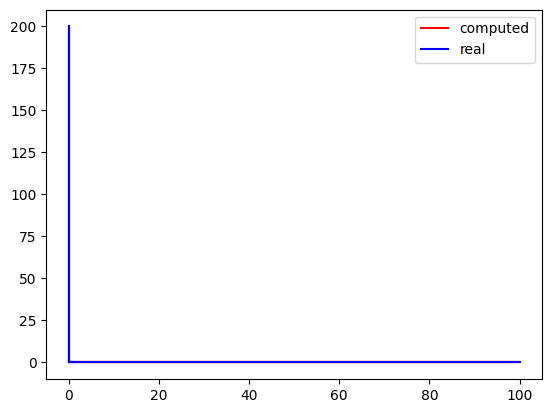

In [34]:
# we assume we have a structured sample in focus
# the sample is moved around and the deltas are measured
# everything has to be inside a thread
# process the slices and compute their relative distances in pixels
# compute shift between images relative to zeroth image
allShiftsComputed = []
rescalingFac = 1 # in case the images are too big we should scale them down! 
for iImage in range(len(mStack)):
    image1 = mStack[0]# cv2.cvtColor(mStack[0], cv2.COLOR_BGR2GRAY)
    image2 = mStack[iImage] #cv2.cvtColor(mStack[iImage], cv2.COLOR_BGR2GRAY)
    
    # downscaling will reduce accuracy, but will speed up computation
    image1 = cv2.resize(image1, dsize=None, dst=None, fx=1/rescalingFac, fy=1/rescalingFac)
    image2 = cv2.resize(image2, dsize=None, dst=None, fx=1/rescalingFac, fy=1/rescalingFac)

    # produces coordinates that can be used to align two imags with the shift function, axis = y,x and image2 on image1
    shift, error, diffphase = phase_cross_correlation(image2, image1)
    shift *=rescalingFac
    allShiftsComputed.append((shift[1],shift[0]))

import matplotlib.pyplot as plt 
# computed positions
x, y = np.array(allShiftsComputed).T
plt.plot(x,y, 'r')
# positions sent to the microscope
xm, ym, z = np.array(positionList).T
plt.plot(xm,ym, 'b')
plt.legend(("computed", "real"))

plt.show()



In [28]:
# random code 



s
# compute averrage shifts according to scan grid 
# compare measured shift with shift given by the array of random coordinats
allShiftsPlanned = np.array(xyScanStepsAbsolute)
allShiftsPlanned -= np.min(allShiftsPlanned,0)
allShiftsComputed = np.array(allShiftsComputed)

# compute differencs
nShiftX = (self.xScanMax-self.xScanMin)//self.xScanStep
nShiftY = (self.yScanMax-self.yScanMin)//self.yScanStep

# determine the axis and swap if necessary (e.g. swap axis (y,x))
dReal = np.abs(allShiftsPlanned-np.roll(allShiftsPlanned,-1,0))
dMeasured = np.abs(allShiftsComputed-np.roll(allShiftsComputed,-1,0))
xAxisReal = np.argmin(np.mean(dReal,0))
xAxisMeasured = np.argmin(np.mean(dMeasured,0))
if xAxisReal != xAxisMeasured:
    xAxisMeasured = np.transposes(xAxisMeasured, (1,0))

# stepsize => real motion / stepsize 
stepSizeStage = (dMeasured*self.pixelSize)/dReal
stepSizeStage[stepSizeStage == np.inf] = 0
stepSizeStage = np.nan_to_num(stepSizeStage, nan=0.)
stepSizeStage = stepSizeStage[np.where(stepSizeStage>0)]
stepSizeStageDim = np.mean(stepSizeStage)
stepSizeStageVar = np.var(stepSizeStage)

self._logger.debug("Stage pixel size: "+str(stepSizeStageDim)+"nm/step")
self._widget.setInformationLabel("Stage pixel size: "+str(stepSizeStageDim)+" nm/step")

# Set in setup info
name="test"
self._setupInfo.setPositionerPreset(name, self.makePreset())
configfiletools.saveSetupInfo(configfiletools.loadOptions()[0], self._setupInfo)





NameError: name 'xyScanStepsAbsolute' is not defined

In [24]:
positionList

[(0, 0, 0), (0, 100, 0), (0, 0, 0), (100, 0, 0), (0, 0, 0)]